# Training for Fraud Detection 
## Part 2: Weighting Imbalanced Classes (Balanced Sub-Sampling)

In [1]:
import pandas as pd
import numpy as np
from scipy import interp
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_recall_curve
#from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns



%matplotlib inline

In [2]:
Xtrain = pd.read_csv('./../data/xtrain.csv')
Xtest = pd.read_csv('./../data/xtest.csv')
ytest = pd.read_csv('./../data/ytest.csv')
ytrain = pd.read_csv('./../data/ytrain.csv')

The idea here is to use training data proportionate to the outcome class distributions. Most scikit learn functions provide for an easy way for the agorithm to work with sub-samples of the data. 

I'll use a random forest classifier with the *class_weights* parameter set to "balanced_subsample". As this constructs numerous sub-trees, it takes into account the weighted distribution of the outcome classes in each sub-tree and traverses each tree on data points that represent each class proportionately. For each tree, the number of samples for majority class == number of samples for the minority class. 

The algorithm achieves this weighting by using a formula like: $Class Weights = m / (k * (class frequencies))$ where m is the number of samples in the bootstrapped sub-tree, k is the number of classes to predict.

In [9]:
#weight of majority class when compared to minority class
float(len(ytrain))/float((ytrain==1).sum())

34.93451957295374

In [23]:
#from our previous exercise, we learned that a good number of trees are around 45 for a RF walk.

clf1 = RandomForestClassifier(n_estimators=45, class_weight='balanced_subsample')
clf1.fit(Xtrain, np.array(ytrain).ravel(), sample_weight=np.where(ytrain==1, float(len(ytrain))/float((ytrain==1).sum()), 1.0).ravel())

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
ypred=(clf1.predict_proba(Xtest)[:,1]>=0.5).astype(int)

In [47]:
print(confusion_matrix(ytest, ypred, labels=[1,0]))

[[  150   811]
 [ 2860 28901]]


In [40]:
print(classification_report(ytest, ypred, labels=[1,0], target_names=['Fraud', 'Not Fraud'],
                            sample_weight=np.where(ytest==1, float(len(ytest))/float((ytest==1).sum()), 1.0).ravel()))

             precision    recall  f1-score   support

      Fraud       0.64      0.16      0.25   32722.0
  Not Fraud       0.51      0.91      0.65   31761.0

avg / total       0.58      0.53      0.45   64483.0



This is rather misleading because we're cross validating with balanced weights. So minority class (TP) is being weighted in the calculations here. This is **not** representative of class prevalence in real world data. 

I'll recalculate the out of sample metrics **without** weighting the minority class. 

In [50]:
print(classification_report(ytest, ypred, labels=[1,0], target_names=['Fraud', 'Not Fraud']))
                     #sample_weight=np.where(ytest==1, float(len(ytest))/float((ytest==1).sum()), 1.0).ravel())

             precision    recall  f1-score   support

      Fraud       0.05      0.16      0.08       961
  Not Fraud       0.97      0.91      0.94     31761

avg / total       0.95      0.89      0.91     32722



Even though the classifier made decisions on balanced subsamples of data, its real world performance is poor, esepcially its *precision* of correctly classifying the cases it thinks of as *fraud*. Changing the Decision Threshold to our previously established ideal of 0.2 might not improve it much.

In [51]:
ypred=(clf1.predict_proba(Xtest)[:,1]>=0.2).astype(int)

In [52]:
print(classification_report(ytest, ypred, labels=[1,0], target_names=['Fraud', 'Not Fraud']))

             precision    recall  f1-score   support

      Fraud       0.07      0.27      0.10       961
  Not Fraud       0.98      0.89      0.93     31761

avg / total       0.95      0.87      0.90     32722



Although the classifier manages to find 27% of fraudulent merchants in the dataset, it still does a poor job of accurately identifying the truly fraudulent ones. The F1-score is worse than the DT thresholding approach.

How do the evaluation curves look?

In [60]:
def plot_ROC_PR(Xtrain, ytrain, k, rf_estimators, class_subsampling=None, cutoff=0.5):
    """
    Plot the ROC curve and AUC metric for given dataset, along with k-fold cross validation.
    Use a Random Forest classifier with ideal number of estimators pre-determined
    """
    cv = StratifiedKFold(np.array(ytrain).ravel(), n_folds=k) #preserves class %
    clf_rf = RandomForestClassifier(n_estimators=rf_estimators, verbose=0, criterion='gini', n_jobs=-1, class_weight=class_subsampling) 
    
    #plt.figure(figsize=(15,7))
    (fig, (ax1, ax2)) = plt.subplots(ncols=1, nrows=2, figsize=(15,10))
    for i, (train, cval) in enumerate(cv):
        clf_rf.fit(Xtrain.iloc[train], np.array(ytrain.iloc[train]).ravel())
                  #sample_weight=np.where(ytrain.iloc[train]==1, float(len(ytrain.iloc[train]))/float((ytrain.iloc[train]==1).sum()), 1.0).ravel())
        probas_ = clf_rf.predict_proba(Xtrain.iloc[cval])
        ypred = (probas_[:,1] >= cutoff).astype(int)
        
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(ytrain.iloc[cval], probas_[:, 1], pos_label=1)
                                        #sample_weight=np.where(ytrain.iloc[cval]==1, float(len(ytrain.iloc[cval]))/float((ytrain.iloc[cval]==1).sum()), 1.0).ravel())
        precision, recall, thresholds = precision_recall_curve(ytrain.iloc[cval], probas_[:,1], pos_label=1)
                                                               #sample_weight=np.where(ytrain.iloc[cval]==1, float(len(ytrain.iloc[cval]))/float((ytrain.iloc[cval]==1).sum()), 1.0).ravel()) 
        f1 = f1_score(ytrain.iloc[cval], ypred, pos_label=1)
                      #sample_weight=np.where(ytrain.iloc[cval]==1, float(len(ytrain.iloc[cval]))/float((ytrain.iloc[cval]==1).sum()), 1.0).ravel())

        #mean_tpr += interp(mean_fpr, fpr, tpr)
        #mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        ax2.plot(recall, precision, lw=1, label='ROC fold %d (F1 = %0.2f)' % (i, f1))
        #ax1.plot(fpr, thresholds, lw=2, label='Decision Threshold at fold %d (%f)' % (i, np.mean(thresholds)))
    
    ax1.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Chance')
    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate\n(% of Genuine Merchants Misclassified for Fraud)')
    ax1.set_ylabel('True Positive Rate\n(% of All Fraudulent Merchants Caught from Dataset)')
    ax1.set_title('Receiver Operating Characteristic\nRandom Forest Classifier (Decision Threshold = {:02.1f})'.format(cutoff))
    ax1.legend(loc="lower right")
    
    #ax2.set_xlim([-0.05, 1.05])
    #ax2.set_ylim([-0.05, 1.05])
    ax2.set_xlabel('Sensitivity\n(% of All Fraudulent Merchants Caught from Dataset)')
    ax2.set_ylabel('Precision\n(% Fraudulent Merchants Correctly Identified)')
    ax2.set_title('Precision-Recall Curve\nRandom Forest Classifier (Decision Threshold = {:02.1f})'.format(cutoff))
    ax2.legend(loc="lower right")


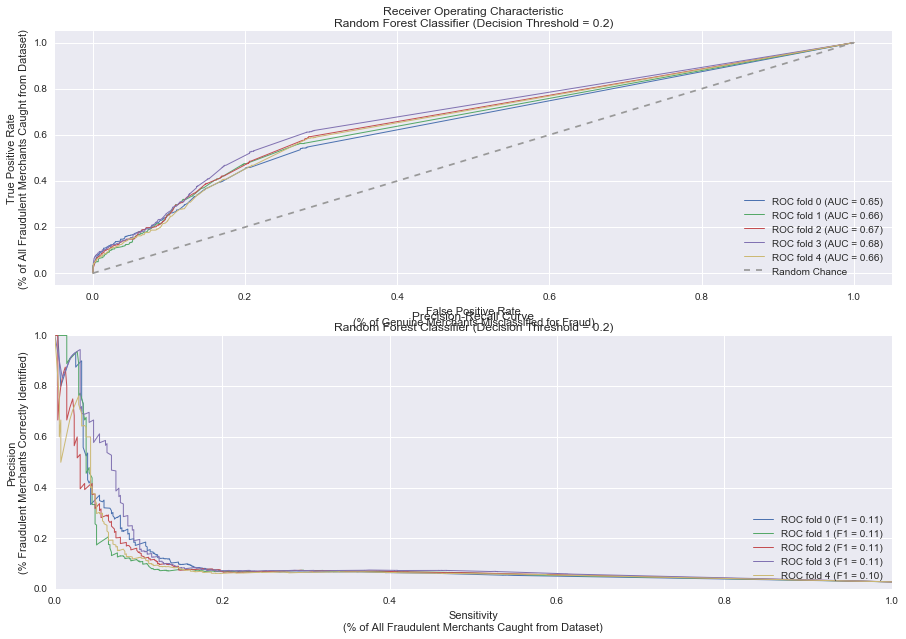

In [61]:
plot_ROC_PR(Xtrain, ytrain, 5, 45, 'balanced_subsample', 0.2)